# MathNarrator

In [1]:
import numpy as np
from math_vocab import MathVocab
from vocabulary import BOS_CODE
from math_dataset import MathDataset
from utils import words_to_sent

voc_path        = "data/math/math_vocab.data"
tr_dataset_path = "data/math/math_dataset_train.data"
va_dataset_path = "data/math/math_dataset_valid.data"
model_path      = 'models/math/narrator-001/'

## Data

In [7]:
voc = MathVocab()
voc.restore(voc_path)

tr_dataset = MathDataset()
tr_dataset.restore(tr_dataset_path)

va_dataset = MathDataset()
va_dataset.restore(va_dataset_path)

## Model

In [13]:
import os
from utils import make_dir
import numpy as np
import tensorflow as tf
import pickle
from visualization import show_train_stats_ex

class BaseModel:
    def __init__(self):
        self._scope    = 'base_model'
        # state
        self.tr_step   = 0
        self.tr_epoch  = 0
        self.tr_losses = []
        self.va_losses = []
    

def make_rnn_cell(num_units, num_layers, keep_prob):
    def make_layer():
        l = tf.contrib.rnn.BasicLSTMCell(num_units)
        l = tf.contrib.rnn.DropoutWrapper(l, output_keep_prob=keep_prob)
        return l        
    layers = [make_layer() for _ in range(num_layers)]
    cell   = tf.contrib.rnn.MultiRNNCell(layers)
    return cell

    
class NarratorModel(BaseModel):
    def __init__(self):
        super().__init__()
        self._scope    = 'narrator'
        
    def _make_loss(self, logits, labels):
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits = logits,
            labels = labels)
        return tf.reduce_mean(loss)
    

    def _make_optimizer(self, loss, lr, grad_clip):
        tr_vars   = tf.trainable_variables()
        grads, _  = tf.clip_by_global_norm(tf.gradients(loss, tr_vars), grad_clip)
        train_op  = tf.train.AdamOptimizer(lr)
        optimizer = train_op.apply_gradients(zip(grads, tr_vars))
        return optimizer
    
    
    def _make_decoder(self, inp, h, num_units, num_layers, voc_size, seq_len, keep_prob):
        cell = make_rnn_cell(num_units, num_layers, keep_prob)
        logits_seq = []

        def loop_function(outputs):
            logits = tf.layers.dense(outputs, voc_size, name='projection')
            token = tf.argmax(logits, axis=1)
            inp = tf.nn.embedding_lookup(self.embedding, token)
            return inp, logits
            
        with tf.variable_scope('decoder', reuse=tf.AUTO_REUSE):
            for t in range(seq_len):
                output, h = cell(inp, h)
                inp, logits = loop_function(output)
                logits_seq.append(tf.expand_dims(logits, 1))

        return tf.concat(logits_seq, 1)
    
    
    def build(self, voc_size, bos_token, emb_size, seq_len, num_units, num_layers, grad_clip=5):
        tf.reset_default_graph()
        self._graph = tf.Graph()
        with self._graph.as_default(), tf.variable_scope(self._scope):
            # placeholders
            self.enc_inputs_pl = tf.placeholder(tf.int32, [None, None], name='enc_inputs')
            self.targets_pl    = tf.placeholder(tf.int32, [None, None], name='targets')
            self.batch_size_pl = tf.placeholder(tf.int32, shape=[], name='batch_size')
            self.keep_prob_pl  = tf.placeholder(tf.float32, name='keep_prob')
            self.lr_pl         = tf.placeholder(tf.float32, name='learning_rate')

            # embedding
            self.embedding     = tf.Variable(tf.random_normal(shape=[voc_size, emb_size], dtype=tf.float32))
            en_inputs          = tf.nn.embedding_lookup(self.embedding, self.enc_inputs_pl)
            bos_tokens         = tf.tile([bos_token], tf.expand_dims(self.batch_size_pl,0))  
            de_inputs          = tf.nn.embedding_lookup(self.embedding, bos_tokens)
            
            # encoder
            en_cell            = make_rnn_cell(num_units, num_layers, self.keep_prob_pl)
            en_initial_state   = en_cell.zero_state(self.batch_size_pl, tf.float32)
            seq_lens           = tf.tile([seq_len], tf.expand_dims(self.batch_size_pl,0))
            _, en_state        = tf.nn.dynamic_rnn(en_cell, en_inputs, seq_lens, en_initial_state, scope='encoder')

            # decoder
            de_logits = self._make_decoder(
                inp        = de_inputs, 
                h          = en_state, 
                num_units  = num_units, 
                num_layers = num_layers,
                voc_size   = voc_size,
                seq_len    = seq_len, 
                keep_prob  = self.keep_prob_pl)

            # prediction
            self.outputs       = tf.argmax(tf.nn.softmax(de_logits), axis=2)

            # training
            self.loss_op       = self._make_loss(de_logits, self.targets_pl)
            self.train_op      = self._make_optimizer(self.loss_op, self.lr_pl, grad_clip)
            
            # utils
            self.init_op       = tf.global_variables_initializer()
            self._saver        = tf.train.Saver()

        # session
        self._sess = tf.Session(graph=self._graph)
        self._sess.run(self.init_op)
        
        
    def train(self, tr_dataset, va_dataset, 
              step_num,  batch_size, learning_rate, keep_prob=.5, log_every=20, mean_win=30):
        try:
            data_size = tr_dataset.get_data_size()
            for self.tr_step in range(self.tr_step, step_num-1):
                ep = self.tr_step*batch_size/data_size
                # Train
                sents = tr_dataset.get_next_batch(batch_size)
                tr_loss, _ = self._sess.run(
                    [self.loss_op, self.train_op], 
                    feed_dict = {
                        self.enc_inputs_pl: sents,
                        self.targets_pl   : sents,
                        self.batch_size_pl: batch_size,
                        self.keep_prob_pl : keep_prob,
                        self.lr_pl        : learning_rate,
                })
                self.tr_losses.append(tr_loss)
                # Eval
                if self.tr_step % log_every == log_every-1:
                    sents = va_dataset.get_next_batch(batch_size)
                    va_loss = self._sess.run(
                        self.loss_op, 
                        feed_dict={
                            self.enc_inputs_pl: sents,
                            self.targets_pl   : sents,
                            self.batch_size_pl: batch_size,
                            self.keep_prob_pl : keep_prob,
                            self.lr_pl        : learning_rate,
                        })
                    self.va_losses.extend([va_loss]*log_every)
                    show_train_stats_ex(ep, self.tr_step, self.tr_losses, self.va_losses, mean_win)
                        
        except KeyboardInterrupt:
            show_train_stats_ex(ep, self.tr_step, self.tr_losses, self.va_losses, mean_win)
            

    def save(self, path):
        make_dir(path)
        pickle.dump([self.tr_epoch, self.tr_step, self.tr_losses, self.va_losses], 
                    open(os.path.join(path, "state.p"), "wb"))
        self._saver.save(self._sess, path)
        
        
    def restore(self, path):
        try:
            [self.tr_epoch, self.tr_step, self.tr_losses, self.va_losses] = pickle.load(
                open(os.path.join(path, "state.p"), "rb"))
        except: 
            print("State not found at", path)
        self._saver.restore(self._sess, path)
        
        
    def run(self, sents, batch_size, seq_length):
        return self._sess.run(
            self.outputs, 
            feed_dict = {
                self.enc_inputs_pl: sents,
                self.targets_pl   : sents,
                self.batch_size_pl: batch_size,
                self.keep_prob_pl : 1,
        })
    
    def get_embeddings(self):
        return self.embedding.eval(self._sess)


## Build

In [14]:
model = NarratorModel()
seq_len = tr_dataset.get_seq_len()
assert seq_len == va_dataset.get_seq_len()

model.build(
    voc_size   = voc.size, 
    bos_token  = BOS_CODE,
    seq_len    = seq_len,
    emb_size   = 100, 
    num_units  = 128, 
    num_layers = 2)

## Train

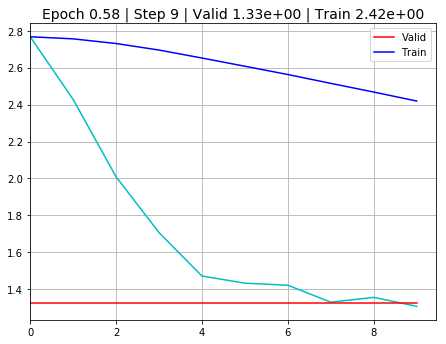

In [ ]:
%%time
%matplotlib inline

model.train(
    step_num      = 10000,
    batch_size    = 64, 
    learning_rate = 1e-3, 
    mean_win      = 30,
    log_every     = 10,
    tr_dataset    = tr_dataset,
    va_dataset    = va_dataset,
)
model.save(model_path)

## Test

In [45]:
batch_size = 10

for dataset in [tr_dataset, va_dataset]:
    print('\n'+'='*80+'\n'+dataset._path)
    inp = dataset.get_next_batch(batch_size)
    out = model.run(inp, batch_size, seq_len)

    def prepare(s):
        words = voc.to_words(s)
        s = "".join(words)
        s = s.replace('<BOS>', '[').replace('<EOS>', ']').replace('<PAD>', '_')
        return s

    for i in range(len(inp)):
        print('-'*50)
        print(prepare(inp[i]))
        print(prepare(out[i]))



data/math/math_dataset_train.data
--------------------------------------------------
[4+1+11 = 16]_____________________
[4+1+11 = 16]_____________________
--------------------------------------------------
[10+1 = 11]_______________________
[10+1 = 11]_______________________
--------------------------------------------------
[3+6+8 = 12+1+4]__________________
[3+6+8 = 12+1+4]__________________
--------------------------------------------------
[1+2+3+2+3+1 = 2+4+6]_____________
[1+2+3+2+3+1 = 2+4+6]_____________
--------------------------------------------------
[2+6+5 = 1+11+1]__________________
[2+6+5 = 1+11+1]__________________
--------------------------------------------------
[3+7 = 8+2]_______________________
[3+7 = 8+2]_______________________
--------------------------------------------------
[7+1+1+1+1+1+1 = 3+1+6+2+1]_______
[7+1+1+1+1+1+1 = 3+1+6+2+1]_______
--------------------------------------------------
[2+4+1+2+1 = 10]__________________
[2+4+1+2+1 = 10]________________

## Restore

In [53]:
model.restore(model_path)

INFO:tensorflow:Restoring parameters from models/rnn_autoencoder/math-001/
